In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest, expon, gamma, erlang, ks_2samp
from fitter import Fitter, get_common_distributions

In [14]:
df = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
df

,Station Name,Start Date,End Date,Port Number,Plug Type,Latitude,Longitude,Id,Total Duration (min),Charging Time (min),Cluster
0,PALO ALTO CA / HAMILTON #1,2011-07-29 20:17:00,2011-07-29 23:20:00,2,J1772,37.444572,-122.160310,0,183.533333,114.050000,HAMILTON
1,PALO ALTO CA / HAMILTON #1,2011-07-30 00:00:00,2011-07-30 00:02:00,2,J1772,37.444572,-122.160310,1,2.100000,1.900000,HAMILTON
2,PALO ALTO CA / HAMILTON #1,2011-07-30 08:16:00,2011-07-30 12:34:00,2,J1772,37.444572,-122.160310,2,257.533333,257.466667,HAMILTON
3,PALO ALTO CA / HAMILTON #1,2011-07-30 14:51:00,2011-07-30 16:55:00,2,J1772,37.444572,-122.160310,3,123.400000,122.966667,HAMILTON
4,PALO ALTO CA / HAMILTON #1,2011-07-30 18:51:00,2011-07-30 20:03:00,2,J1772,37.444572,-122.160310,4,71.400000,43.900000,HAMILTON
...,...,...,...,...,...,...,...,...,...,...,...
259410,PALO ALTO CA / TED THOMPSON #3,2020-12-31 16:39:00,2020-12-31 17:14:00,2,J1772,37.428623,-122.144040,259410,35.733333,35.300000,TED
259411,PALO ALTO CA / WEBSTER #1,2020-12-31 16:48:00,2020-12-31 20:31:00,2,J1772,37.448284,-122.158270,259411,223.016667,134.066667,WEBSTER
259412,PALO ALTO CA / MPL #4,2020-12-31 17:28:00,2021-01-01 10:56:00,1,J1772,37.422104,-122.113510,259412,1048.233333,308.200000,MPL
259413,PALO ALTO CA / WEBSTER #1,2020-12-31 17:49:00,2020-12-31 21:55:00,1,J1772,37.448284,-122.158270,259413,245.566667,233.700000,WEBSTER


In [15]:
print("Median: ", df["Total Duration (min)"].median())
df["Total Duration (min)"].describe()

Median:  125.35


count    259415.000000
mean        149.209249
std         132.759684
min           1.000000
25%          70.250000
50%         125.350000
75%         185.400000
max        6872.350000
Name: Total Duration (min), dtype: float64

In [16]:

# Remove outliers
df = df[df["Total Duration (min)"] < 2000]

In [17]:
rsv = df["Total Duration (min)"].values

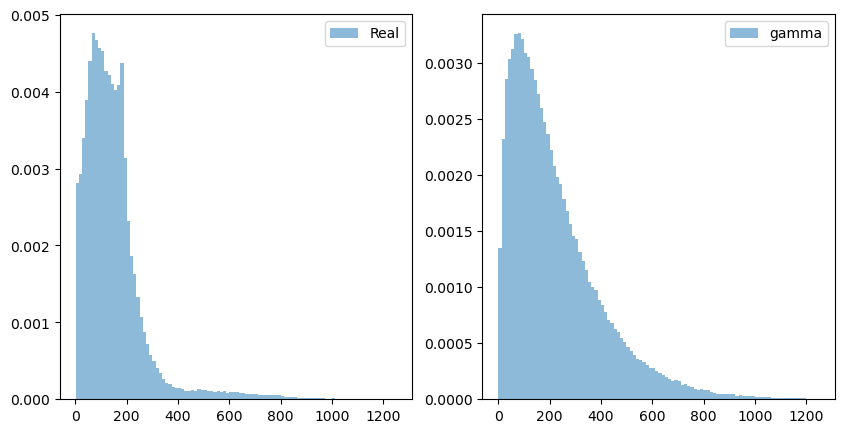

KstestResult(statistic=0.24395151963732242, pvalue=0.0, statistic_location=210.6833333333333, statistic_sign=1)

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# cdf = expon.rvs(size=len(rsv), scale=rsv.mean())
cdf = gamma.rvs(a=1.5, size=len(rsv), scale=rsv.mean())

axs[0].hist(rsv[rsv < 1250], bins=100, label="Real", alpha=0.5, density=True)
axs[0].legend()
axs[1].hist(cdf[cdf < 1250], bins=100, label="gamma", alpha=0.5, density=True)
axs[1].legend()
plt.show()
kstest(rsv, cdf)

Fitting 12 distributions: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


{'erlang': {'a': 1.7522550521120357,
  'loc': -2.0089988147278683,
  'scale': 85.36143654665662}}

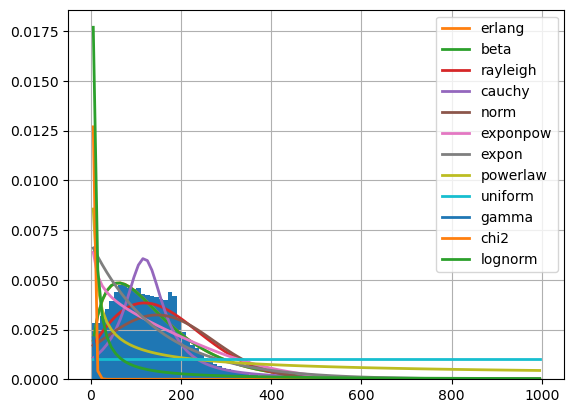

In [19]:
f = Fitter(
    rsv, 
    timeout=10000, 
    distributions=get_common_distributions()  + ["erlang", "beta"],
    xmax=1000,
    )
f.fit(max_workers=8)
f.summary(Nbest=12)
f.get_best(method = 'sumsquare_error')


Exponential params FitParams(loc=0.9467242000058036, scale=148.93268020178982)
Gamma params FitParams(a=1.6211589559934905, loc=0.0, scale=91.92888330720197)
Erlang params FitParams(a=2.0, loc=0.0, scale=74.51549721607451)


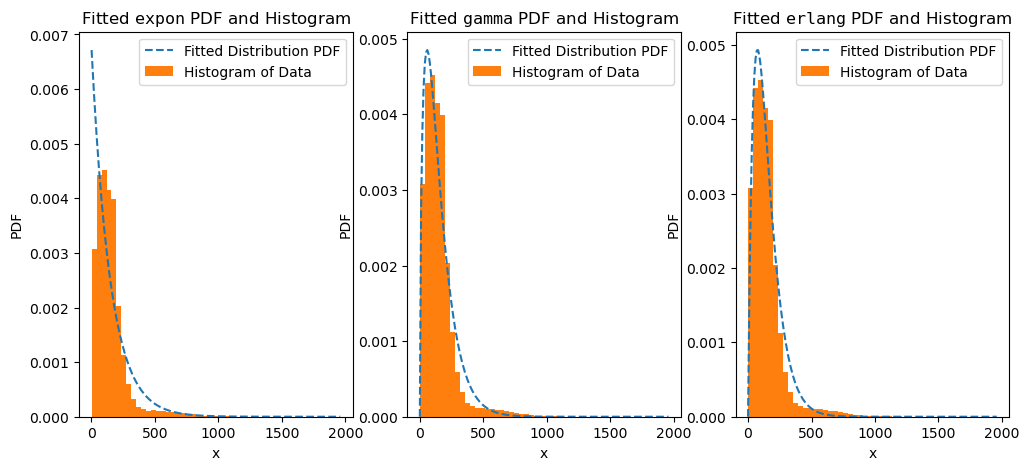

In [20]:
from scipy.stats import fit 
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
# Exponential
bounds = [(0, 1000), (0, 1000)]
res_exp = fit(expon, rsv, bounds=bounds)
res_exp.plot(ax=axs[0])
print("Exponential params", res_exp.params)

# Gamma
bounds = [(0, 1000), (0, 1000), (0, 1000)]
res_gamma = fit(gamma, rsv, bounds=bounds)
res_gamma.plot(ax=axs[1])
print("Gamma params", res_gamma.params)

# Erlang 
bounds = [(0, 1000), (0, 1000), (0, 1000)]
res_erlang = fit(erlang, rsv, bounds=bounds)
res_erlang.plot(ax=axs[2])
print("Erlang params", res_erlang.params)


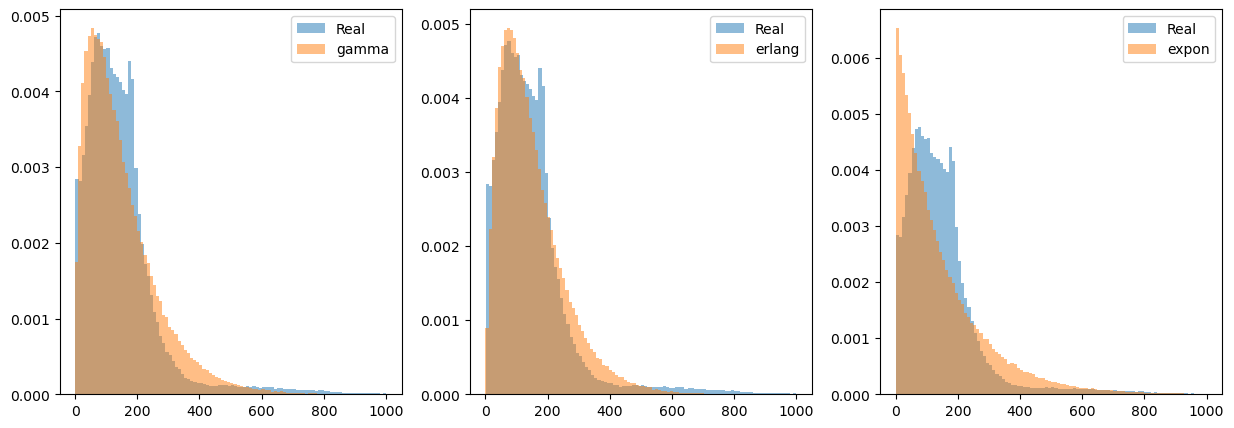

KstestResult(statistic=0.060794939750756005, pvalue=0.0, statistic_location=215.26666666666668, statistic_sign=1)
KstestResult(statistic=0.05285124789727769, pvalue=4.360889543e-315, statistic_location=204.86666666666667, statistic_sign=1)
KstestResult(statistic=0.12986612178849644, pvalue=0.0, statistic_location=56.849127931683554, statistic_sign=-1)


In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# cdf = expon.rvs(size=len(rsv), scale=rsv.mean())
cdf_gamma = gamma.rvs(a=res_gamma.params.a, size=len(rsv), scale=res_gamma.params.scale)

axs[0].hist(rsv[rsv < 1000], bins=100, label="Real", alpha=0.5, density=True)
axs[0].hist(cdf_gamma[cdf_gamma < 1000], bins=100, label="gamma", alpha=0.5, density=True)
axs[0].legend()
cdf_erlang = erlang.rvs(a=res_erlang.params.a, size=len(rsv), scale=res_erlang.params.scale)
axs[1].hist(rsv[rsv < 1000], bins=100, label="Real", alpha=0.5, density=True)
axs[1].hist(cdf_erlang[cdf_erlang < 1000], bins=100, label="erlang", alpha=0.5, density=True)
axs[1].legend()

cdf_expon = expon.rvs(size=len(rsv), scale=res_exp.params.scale)
axs[2].hist(rsv[rsv < 1000], bins=100, label="Real", alpha=0.5, density=True)
axs[2].hist(cdf_expon[cdf_expon < 1000], bins=100, label="expon", alpha=0.5, density=True)
axs[2].legend()
plt.show()
print(ks_2samp(rsv[rsv < 1000], cdf_gamma))
print(ks_2samp(rsv[rsv < 1000], cdf_erlang))
print(ks_2samp(rsv[rsv < 1000], cdf_expon))

